<a href="https://colab.research.google.com/github/bonten999/SQLite.jl/blob/master/%E5%8F%82%E8%80%83_%E3%83%86%E3%82%AD%E3%82%B9%E3%83%88%E3%82%AB%E3%82%A6%E3%83%B3%E3%83%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#テキストファイルから単語数をカウントする

In [ ]:
#@title ドライブ接続
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
a= input("plese input file path.")

plese input file path.


In [ ]:
#@title Mecabインストール
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.996.3
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
  swig3.0
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp

In [ ]:
#@title 分析環境のセットアップ
#!pip install ginza
!git clone https://github.com/amueller/word_cloud
!cd word_cloud && python setup.py install
!pip install scattertext jieba empath astropy gensim umap-learn
!apt install fonts-takao-pgothic
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

In [ ]:
#@title MixWordモジュール Colab用
import MeCab
import re
import time
import sys
import subprocess

neologd_cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
neologd_path = (subprocess.Popen(neologd_cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
mecabIpadicPath_str = neologd_path


op_surface_str = "-F%M/n -E/t"
op_origin_str = "-F%f[6]/n -E/t"
op_PosStr_str = "-F%f[0]/n -E/t"
op_PosId_str = "-F%h/n -E/t"

op_surfaceNeologd_str = "-d " + mecabIpadicPath_str + " " + op_surface_str
op_originNeologd_str = "-d " + mecabIpadicPath_str + " " + op_origin_str
op_PosStrNeologd_str = "-d " + mecabIpadicPath_str + " " + op_PosStr_str
op_PosIdNeologd_str = "-d " + mecabIpadicPath_str + " " + op_PosId_str

mecab_surface = MeCab.Tagger(op_surface_str)
mecab_surface.parse("")
mecab_origin = MeCab.Tagger(op_origin_str)
mecab_origin.parse("")
mecab_PosStr = MeCab.Tagger(op_PosStr_str)
mecab_PosStr.parse("")
mecab_PosId = MeCab.Tagger(op_PosId_str)
mecab_PosId.parse("")

mecab_surfaceNeologd = MeCab.Tagger(op_originNeologd_str)
mecab_surfaceNeologd.parse("")
mecab_originNeologd = MeCab.Tagger(op_originNeologd_str)
mecab_originNeologd .parse("")
mecab_PosStrNeologd = MeCab.Tagger(op_PosStrNeologd_str)
mecab_PosStrNeologd.parse("")
mecab_PosIdNeologd = MeCab.Tagger(op_PosIdNeologd_str)
mecab_PosIdNeologd.parse("")

def fn_getCleanSentece_str(sentence_str):
    sentence_str = sentence_str.strip()
    sentence_str = re.sub("\s|[.]|,|;|:|[\]|#|$|!|&|%|[(]|[)]|=|{|}[*]|[+]|[?]|<|>|~|[|]/", "・", sentence_str)
    return sentence_str

def fn_getMixWord_ary(sentence_str):
    """

    :param sentence_str:
    :return: 複合語と単語両方　複合語で記されている場合は単語は戻らない　「北海道ラーメン」－＞戻り値「北海道ラーメン」　戻らない「北海道」｢ラーメン」
    """

    surface_str = mecab_surface.parse(sentence_str)
    posStr_str = mecab_PosStr.parse(sentence_str)
    _result_ary = []
    _mixWord_ary = []


    surface_strAry = surface_str .split("/n")
    posStr_strAry = posStr_str.split("/n")

    for position_num in range(len(surface_strAry)-1):
        #print(surface_strAry[position_num],posStr_strAry[position_num])
        if posStr_strAry[position_num] == "名詞":
            _mixWord_ary.append(surface_strAry[position_num].strip())
        else:
            if len(_mixWord_ary):
                _result_ary.append("".join(_mixWord_ary))
                _mixWord_ary =[]

    if len(_mixWord_ary):
        _result_ary.append("".join(_mixWord_ary).strip())

    return _result_ary


#----sigleWord---------------

def fn_getSingleWordWakati_ary(sentence_str):
    surface_str = mecab_surface.parse(sentence_str)
    surface_strAry = surface_str.split("/n")
    return surface_strAry[:-1]

def fn_getSingleWordWakatiNV_ary(sentence_str):
    surface_str = mecab_surface.parse(sentence_str)
    posStr_str = mecab_PosStr.parse(sentence_str)
    _result_ary = []

    surface_strAry = surface_str.split("/n")
    posStr_strAry = posStr_str.split("/n")
    for position_num in range(len(surface_strAry)):
        if posStr_strAry[position_num] == "名詞"  :
            _result_ary.append(surface_strAry[position_num])
        if posStr_strAry[position_num] == "動詞" :
            _result_ary.append(surface_strAry[position_num])
    return [_txt.strip() for _txt in _result_ary if _txt !="/t"]

def fn_getSingleOriginWordWakati_ary(sentence_str):
    origin_str = mecab_origin.parse(sentence_str)
    surface_str = mecab_surface.parse(sentence_str)
    origin_strAry = origin_str.split("/n")
    surface_strAry = surface_str.split("/n")
    _result_ary = []
    for _positon_num in range(len(surface_strAry)):
        if len(origin_strAry[_positon_num])==0:
            _result_ary.append(surface_strAry[_positon_num])
        else:
            _result_ary.append(origin_strAry[_positon_num])
    return [_txt.strip() for _txt in _result_ary if _txt !="/t"]

def fn_getSingleOriginWordWakatiNV_ary(sentence_str):
    surface_str = mecab_surface.parse(sentence_str)
    origin_str = mecab_origin.parse(sentence_str)
    posStr_str = mecab_PosStr.parse(sentence_str)
    _result_ary = []

    surface_strAry = surface_str .split("/n")
    origin_strAry = origin_str.split("/n")
    posStr_strAry = posStr_str.split("/n")

    for position_num in range(len(surface_strAry)):
        if posStr_strAry[position_num] == "名詞"  :
            _result_ary.append(surface_strAry[position_num])
        if posStr_strAry[position_num] == "動詞" :
            _result_ary.append(origin_strAry[position_num])

    return [_txt.strip() for _txt in _result_ary if _txt !="/t"]

#todo fn_getSingleWordNV_ary つくること？？


#----mixWord---------------

def fn_getMixWordWakati_ary(sentence_str):
    """

    :param sentence_str:
    :return: 複合語と単語両方　複合語で記されている場合は単語は戻らない　「北海道ラーメン」－＞戻り値「北海道ラーメン」　戻らない「北海道」｢ラーメン」
    """

    surface_str = mecab_surface.parse(sentence_str)
    posStr_str = mecab_PosStr.parse(sentence_str)
    _result_ary = []
    _mixWord_ary = []


    surface_strAry = surface_str.split("/n")
    posStr_strAry = posStr_str.split("/n")

    for position_num in range(len(surface_strAry)-1):
        #print(surface_strAry[position_num],posStr_strAry[position_num])
        if posStr_strAry[position_num] == "名詞":
            #print("名詞")
            _mixWord_ary.append(surface_strAry[position_num])
        else:
            if len(_mixWord_ary):
                _result_ary.append("".join(_mixWord_ary))
                _mixWord_ary =[]
                _result_ary.append(surface_strAry[position_num])
            else:
                _result_ary.append(surface_strAry[position_num])

    #最後の文字は/tなので
    if len(_mixWord_ary)>0 :
        _result_ary.append("".join(_mixWord_ary))

    return [_txt.strip() for _txt in _result_ary if _txt !="/t"]

def fn_getMixWordWakatiNV_ary(sentence_str):
    """

    :param sentence_str:
    :return: 複合語と単語両方　複合語で記されている場合は単語は戻らない　「北海道ラーメン」－＞戻り値「北海道ラーメン」　戻らない「北海道」｢ラーメン」
    """

    surface_str = mecab_surface.parse(sentence_str)
    posStr_str = mecab_PosStr.parse(sentence_str)
    _result_ary = []
    _mixWord_ary = []


    surface_strAry = surface_str.split("/n")
    posStr_strAry = posStr_str.split("/n")

    for position_num in range(len(surface_strAry)-1):
        #print(surface_strAry[position_num],posStr_strAry[position_num])
        if posStr_strAry[position_num] == "名詞":
            #print("名詞")
            _mixWord_ary.append(surface_strAry[position_num])
        else:
            if len(_mixWord_ary):
                _result_ary.append("".join(_mixWord_ary))
                _mixWord_ary =[]
                if posStr_strAry[position_num] == "動詞":
                    _result_ary.append(surface_strAry[position_num])
            else:

                if posStr_strAry[position_num] == "動詞":
                    _result_ary.append(surface_strAry[position_num])

    #最後の文字は/tなので
    if len(_mixWord_ary)>0 :
        _result_ary.append("".join(_mixWord_ary))
    return [_txt.strip() for _txt in _result_ary if _txt !="/t"]


def fn_getMixWordWakatiNeologd_ary(sentence_str):
    mixSurfaceNeologd_str = mecab_surfaceNeologd.parse(sentence_str)
    mixSurfaceNeologd_strAry= mixSurfaceNeologd_str.split("/n")
    return mixSurfaceNeologd_strAry[:-1]

def fn_getMixWordWakatiNeologdNV_ary(sentence_str):
    mixSurfaceNeologd_str = mecab_surfaceNeologd.parse(sentence_str)
    mixPosStrNeologd_str = mecab_PosStrNeologd.parse(sentence_str)

    mixSurfaceNeologd_strAry= mixSurfaceNeologd_str.split("/n")
    mixPosStrNeologd_strAry = mixPosStrNeologd_str.split("/n")


    return [mixSurfaceNeologd_strAry[position_num] for position_num in range(len(mixSurfaceNeologd_strAry)-1)
            if mixPosStrNeologd_strAry[position_num]=="名詞" or mixPosStrNeologd_strAry[position_num]=="動詞"]

def fn_getMixOriginWordWakati_ary(sentence_str):
    """

    :param sentence_str:
    :return: 複合語と単語両方　複合語で記されている場合は単語は戻らない　「北海道ラーメン」－＞戻り値「北海道ラーメン」　戻らない「北海道」｢ラーメン」
    """

    surface_str = mecab_surface.parse(sentence_str)
    orign_str = mecab_origin.parse(sentence_str)
    posStr_str = mecab_PosStr.parse(sentence_str)
    _result_ary = []
    _mixWord_ary = []

    surface_strAry = surface_str.split("/n")
    orign_strAry = orign_str.split("/n")
    posStr_strAry = posStr_str.split("/n")

    for position_num in range(len(surface_strAry)-1):
        #print(surface_strAry[position_num],posStr_strAry[position_num])
        if posStr_strAry[position_num] == "名詞":
            #print("名詞")
            if orign_strAry[position_num] =="":
                _word_str = surface_strAry[position_num]
            else:
                _word_str = orign_strAry[position_num]
            _mixWord_ary.append(_word_str.strip())
        else:
            if len(_mixWord_ary):
                _result_ary.append("".join(_mixWord_ary))
                _mixWord_ary =[]
                _result_ary.append(surface_strAry[position_num])
            else:
                _result_ary.append(surface_strAry[position_num])

    if len(_mixWord_ary):
        _result_ary.append("".join(_mixWord_ary))

    return [_txt.strip() for _txt in _result_ary if _txt !="/t"]

def fn_getMixOriginWordWakatiNV_ary(sentence_str):
    """

    :param sentence_str:
    :return: 複合語と単語両方　複合語で記されている場合は単語は戻らない　「北海道ラーメン」－＞戻り値「北海道ラーメン」　戻らない「北海道」｢ラーメン」
    """

    surface_str = mecab_surface.parse(sentence_str)
    orign_str = mecab_origin.parse(sentence_str)
    posStr_str = mecab_PosStr.parse(sentence_str)
    _result_ary = []
    _mixWord_ary = []

    surface_strAry = surface_str.split("/n")
    orign_strAry = orign_str.split("/n")
    posStr_strAry = posStr_str.split("/n")

    for position_num in range(len(surface_strAry)-1):
        if orign_strAry[position_num] == "":
            _word_str = surface_strAry[position_num]
        else:
            _word_str = orign_strAry[position_num]

        if posStr_strAry[position_num] == "名詞":

            _mixWord_ary.append(_word_str.strip())
        else:
            if len(_mixWord_ary):
                _result_ary.append("".join(_mixWord_ary))
                _mixWord_ary =[]
                if posStr_strAry[position_num] == "動詞":
                    _result_ary.append(_word_str)
            else:
                if posStr_strAry[position_num] == "動詞":
                    _result_ary.append(_word_str)

    if len(_mixWord_ary):
        _result_ary.append("".join(_mixWord_ary))

    return _result_ary

def fn_getMixOriginWordWakatiNeologd_ary(sentence_str):
    mixSurfaceNeologd_str = mecab_surfaceNeologd.parse(sentence_str)
    mixOriginNeologd_str = mecab_originNeologd.parse(sentence_str)

    mixSurfaceNeologd_strAry= mixSurfaceNeologd_str.split("/n")
    mixOriginNeologd_strAry = mixOriginNeologd_str.split("/n")

    _result_ary =[]
    for position_num in range(len(mixSurfaceNeologd_strAry)-1):
        if mixOriginNeologd_strAry[position_num] =="":
            _result_ary.append(mixSurfaceNeologd_strAry[position_num])
        else:
            _result_ary.append(mixOriginNeologd_strAry[position_num])

    return _result_ary

def fn_getMixOriginWordWakatiNeologdNV_ary(sentence_str):
    mixSurfaceNeologd_str = mecab_surfaceNeologd.parse(sentence_str)
    mixOriginNeologd_str = mecab_originNeologd.parse(sentence_str)
    mixPosStrNeologd_str = mecab_PosStrNeologd.parse(sentence_str)

    mixSurfaceNeologd_strAry= mixSurfaceNeologd_str.split("/n")
    mixOriginNeologd_strAry = mixOriginNeologd_str.split("/n")
    mixPosStrNeologd_strAry = mixPosStrNeologd_str.split("/n")
    _result_ary =[]

    for position_num in range(len(mixSurfaceNeologd_strAry)):
        if mixPosStrNeologd_strAry[position_num] == "名詞" or mixPosStrNeologd_strAry[position_num] == "動詞":
            if mixOriginNeologd_strAry[position_num] =="":
                _result_ary.append(mixSurfaceNeologd_strAry[position_num])
            else:
                _result_ary.append(mixOriginNeologd_strAry[position_num])

    return _result_ary


def fn_getMixOriginWordNV_ary(sentence_str):
    """

    :param sentence_str:
    :return: 複合語と単語両方　複合語で記されている場合は単語は戻らない　「北海道ラーメン」－＞戻り値「北海道ラーメン」　戻らない「北海道」｢ラーメン」
    """

    surface_str = mecab_surface.parse(sentence_str)
    origin_str = mecab_origin.parse(sentence_str)
    posStr_str = mecab_PosStr.parse(sentence_str)
    _result_ary = []
    _mixWord_ary = []


    surface_strAry = surface_str.split("/n")
    origin_strAry = origin_str.split("/n")
    posStr_strAry = posStr_str.split("/n")

    for position_num in range(len(surface_strAry)-1):
        #print(surface_strAry[position_num],posStr_strAry[position_num])
        if posStr_strAry[position_num] == "名詞" :
            #print("名詞")
            _mixWord_ary.append(surface_strAry[position_num].strip())
        else:
            _word_str = origin_strAry[position_num]
            if len(_mixWord_ary):
                _result_ary.append("".join(_mixWord_ary))
                _mixWord_ary =[]
                if posStr_strAry[position_num] == "動詞":
                    _result_ary.append(_word_str)
            else:
                if posStr_strAry[position_num] == "動詞":
                    _result_ary.append(_word_str)

    if len(_mixWord_ary):
        _result_ary.append("".join(_mixWord_ary))

    else:
        if posStr_strAry[len(surface_strAry)-1] == "動詞":
            _result_ary.append(surface_strAry[-1])

    return [_txt.strip() for _txt in _result_ary if _txt !="/t"]

def fn_getMixOriginWordNVNeologd_ary(sentence_str):

    surface_str = mecab_surfaceNeologd.parse(sentence_str)
    origin_str = mecab_originNeologd.parse(sentence_str)
    posStr_str = mecab_PosStrNeologd.parse(sentence_str)
    _result_ary = []


    surface_strAry = surface_str.split("/n")
    origin_strAry = origin_str.split("/n")
    posStr_strAry = posStr_str.split("/n")

    for position_num in range(len(surface_strAry)):
        #print(surface_strAry[position_num],posStr_strAry[position_num])

        if posStr_strAry[position_num] == "動詞":
            _result_ary.append( origin_strAry[position_num])

        if posStr_strAry[position_num] == "名詞":
            _result_ary.append(surface_strAry[position_num])

    return [_txt.strip() for _txt in _result_ary if _txt !="/t"]

#----sigleWord with POS---------------

def fn_getSingleWordWakatiPos_tupAry(sentence_str):
    surface_str = mecab_surface.parse(sentence_str)
    posId_str = mecab_PosId.parse(sentence_str)
    surface_strAry = surface_str.split("/n")
    posId_strAry = posId_str.split("/n")
    result_tupAry = [(surface_strAry[_num].strip(),int(posId_strAry[_num])) for _num in range(len(surface_strAry)-1) ]
    return [(result_tup[0],int(result_tup[1])) for result_tup in result_tupAry]

def fn_getSingleWordWakatiNVPos_tupAry(sentence_str):
    surface_str = mecab_surface.parse(sentence_str)
    posId_str = mecab_PosId.parse(sentence_str)
    surface_strAry = surface_str.split("/n")
    posId_strAry = posId_str.split("/n")
    result_tupAry = [(surface_strAry[_num].strip(),int(posId_strAry[_num])) for _num in range(len(surface_strAry)-1)
                     if 31 <= int(posId_strAry[_num]) and int(posId_strAry[_num]) >= 33
                     or 36 <= int(posId_strAry[_num]) and int(posId_strAry[_num]) >= 67 ]
    return result_tupAry

def fn_getSingleOriginWordWakatiPos_tupAry(sentence_str):
    origin_str = mecab_origin.parse(sentence_str)
    surface_str = mecab_surface.parse(sentence_str)
    posId_str = mecab_PosId.parse(sentence_str)
    origin_strAry = origin_str.split("/n")
    surface_strAry = surface_str.split("/n")
    posId_strAry = posId_str.split("/n")
    _result_tupAry = []
    for _position_num in range(len(surface_strAry)-1):
        if 31 >= int(posId_strAry[_position_num]) and int(posId_strAry[_position_num]) <= 33 \
                or 36 >= int(posId_strAry[_position_num]) and int(posId_strAry[_position_num]) <= 67:
            continue
        if len(origin_strAry[_position_num])==0:

            _result_tupAry.append((surface_strAry[_position_num],int(posId_strAry[_position_num])))
        else:
            _result_tupAry.append((origin_strAry[_position_num],int(posId_strAry[_position_num])))

    return _result_tupAry

def fn_getSingleOriginWordWakatiNVPos_tupAry(sentence_str):
    origin_str = mecab_origin.parse(sentence_str)
    surface_str = mecab_surface.parse(sentence_str)
    posId_str = mecab_PosId.parse(sentence_str)
    origin_strAry = origin_str.split("/n")
    surface_strAry = surface_str.split("/n")
    posId_strAry = posId_str.split("/n")
    _result_tupAry = []
    for _position_num in range(len(surface_strAry)-1):


        if len(origin_strAry[_position_num])==0:

            _result_tupAry.append((surface_strAry[_position_num],int(posId_strAry[_position_num])))
        else:
            _result_tupAry.append((origin_strAry[_position_num],int(posId_strAry[_position_num])))

    return _result_tupAry

def fn_getSingleOriginWordNVPos_ary(sentence_str):
    surface_str = mecab_surface.parse(sentence_str)
    origin_str = mecab_origin.parse(sentence_str)
    posStr_str = mecab_PosStr.parse(sentence_str)
    posId_str = mecab_PosId.parse(sentence_str)
    _result_tupAry = []

    surface_strAry = surface_str .split("/n")
    origin_strAry = origin_str.split("/n")
    posStr_strAry = posStr_str.split("/n")
    posId_strAry = posId_str.split("/n")

    for position_num in range(len(surface_strAry)-1):
        if posStr_strAry[position_num] == "名詞"  :
            _result_tupAry.append((surface_strAry[position_num],int(posId_strAry[position_num])))
        if posStr_strAry[position_num] == "動詞" :
            _result_tupAry.append((origin_strAry[position_num],int(posId_strAry[position_num])))

    return _result_tupAry

#----mixWord with POS---------------

def fn_getMixWordWakatiPos_tupAry(sentence_str):
    """

    :param sentence_str:
    :return: 複合語と単語両方　複合語で記されている場合は単語は戻らない　「北海道ラーメン」－＞戻り値「北海道ラーメン」　戻らない「北海道」｢ラーメン」
    """

    surface_str = mecab_surface.parse(sentence_str)
    posStr_str = mecab_PosStr.parse(sentence_str)
    posId_str = mecab_PosId.parse(sentence_str)
    _result_tupAry = []
    _mixWord_ary = []
    _beforeMixWordPosId_strNum =""


    surface_strAry = surface_str.split("/n")
    posStr_strAry = posStr_str.split("/n")
    posId_strAry = posId_str.split("/n")

    for position_num in range(len(surface_strAry)-2):
        if posStr_strAry[position_num] == "名詞":
            #print("名詞")
            _mixWord_ary.append(surface_strAry[position_num])
            _beforeMixWordPosId_strNum = posId_strAry[position_num]
        else:
            if len(_mixWord_ary):
                _posId_str = "41"
                if len(_mixWord_ary)==1:
                    _posId_str = _beforeMixWordPosId_strNum
                else:
                    _result_tupAry.append(("".join(_mixWord_ary),int(_posId_str)))
                _mixWord_ary =[]
            _result_tupAry.append((surface_strAry[position_num], int(posId_strAry[position_num])))
    return _result_tupAry

def fn_getMixWordWakatiNVPos_tupAry(sentence_str):
    """

    :param sentence_str:
    :return: 複合語と単語両方　複合語で記されている場合は単語は戻らない　「北海道ラーメン」－＞戻り値「北海道ラーメン」　戻らない「北海道」｢ラーメン」
    """

    surface_str = mecab_surface.parse(sentence_str)
    posStr_str = mecab_PosStr.parse(sentence_str)
    posId_str = mecab_PosId.parse(sentence_str)
    _result_tupAry = []
    _mixWord_ary = []
    _beforeMixWordPosId_strNum =""


    surface_strAry = surface_str.split("/n")
    posStr_strAry = posStr_str.split("/n")
    posId_strAry = posId_str.split("/n")

    for position_num in range(len(surface_strAry)-2):
        if posStr_strAry[position_num] == "名詞":
            # print("名詞")
            _mixWord_ary.append(surface_strAry[position_num])
            _beforeMixWordPosId_strNum = posId_strAry[position_num]
        else:
            if len(_mixWord_ary):
                _posId_str = "41"
                if len(_mixWord_ary) == 1:
                    _posId_str = _beforeMixWordPosId_strNum
                else:
                    _result_tupAry.append(("".join(_mixWord_ary), int(_posId_str)))
                _mixWord_ary = []
        if posStr_strAry[position_num] == "動詞":
            _result_tupAry.append((surface_strAry[position_num], int(posId_strAry[position_num])))




    return _result_tupAry


def fn_getMixWordWakatiNeologdPos_tupAry(sentence_str):
    surface_str = mecab_surfaceNeologd.parse(sentence_str)
    posId_str = mecab_PosIdNeologd.parse(sentence_str)
    surface_strAry = surface_str.split("/n")
    posId_strAry = posId_str.split("/n")
    result_tupAry = [(surface_strAry[_num].strip(),int(posId_strAry[_num])) for _num in range(len(surface_strAry)-1)]
    return result_tupAry

def fn_getMixWordWakatiNeologdNVPos_tupAry(sentence_str):
    surface_str = mecab_surfaceNeologd.parse(sentence_str)
    posId_str = mecab_PosIdNeologd.parse(sentence_str)
    posStr_str = mecab_PosStrNeologd.parse(sentence_str)
    surface_strAry = surface_str.split("/n")
    posId_strAry = posId_str.split("/n")
    posStr_strAry = posStr_str.split("/n")

    result_tupAry = [(surface_strAry[_num].strip(),int(posId_strAry[_num])) for _num in range(len(surface_strAry)-1)
                     if posStr_strAry[_num]=="動詞" or  posStr_strAry[_num]=="名詞"]
    return result_tupAry

def fn_getMixOriginWordWakatiPos_tupAry(sentence_str):
    """

    :param sentence_str:
    :return: 複合語と単語両方　複合語で記されている場合は単語は戻らない　「北海道ラーメン」－＞戻り値「北海道ラーメン」　戻らない「北海道」｢ラーメン」
    """

    surface_str = mecab_surface.parse(sentence_str)
    origin_str = mecab_origin.parse(sentence_str)
    posStr_str = mecab_PosStr.parse(sentence_str)
    posId_str = mecab_PosId.parse(sentence_str)
    _result_ary = []
    _mixWord_ary = []
    _beforeMixWordPosId_strNum =""


    surface_strAry = surface_str.split("/n")
    origin_strAry = origin_str.split("/n")
    posStr_strAry = posStr_str.split("/n")
    posId_strAry = posId_str.split("/n")

    for position_num in range(len(surface_strAry)-2):
        #print(surface_strAry[position_num],posStr_strAry[position_num])
        if posStr_strAry[position_num] == "名詞":
            #print("名詞")
            if origin_strAry[position_num]=="":
                _word_str = surface_strAry[position_num]
            else:
                _word_str = origin_strAry[position_num]
            _mixWord_ary.append(_word_str)
            _beforeMixWordPosId_strNum = posId_strAry[position_num]
        else:
            if len(_mixWord_ary):
                _posId_str = "41"
                if len(_mixWord_ary)==1:
                    _posId_str = _beforeMixWordPosId_strNum
                _result_ary.append(("".join(_mixWord_ary),int(_posId_str)))
                _mixWord_ary =[]
                _result_ary.append((surface_strAry[position_num],int(posId_strAry[position_num])))
            else:
                _result_ary.append((surface_strAry[position_num],int(posId_strAry[position_num])))

    if len(_mixWord_ary):
        _posId_str = "41"
        if len(_mixWord_ary) == 1:
            _posId_str = _beforeMixWordPosId_strNum
        _result_ary.append(("".join(_mixWord_ary),int(_posId_str)))
    else:
        if len(surface_strAry)>1:
            _result_ary.append((surface_strAry[-2],int(posId_strAry[-2])))

    return _result_ary

def fn_getMixOriginWordWakatiNVPos_tupAry(sentence_str):
    """

    :param sentence_str:
    :return: 複合語と単語両方　複合語で記されている場合は単語は戻らない　「北海道ラーメン」－＞戻り値「北海道ラーメン」　戻らない「北海道」｢ラーメン」
    """

    surface_str = mecab_surface.parse(sentence_str)
    origin_str = mecab_origin.parse(sentence_str)
    posStr_str = mecab_PosStr.parse(sentence_str)
    posId_str = mecab_PosId.parse(sentence_str)
    _result_ary = []
    _mixWord_ary = []
    _beforeMixWordPosId_strNum =""


    surface_strAry = surface_str.split("/n")
    origin_strAry = origin_str.split("/n")
    posStr_strAry = posStr_str.split("/n")
    posId_strAry = posId_str.split("/n")

    for position_num in range(len(surface_strAry)-2):
        #print(surface_strAry[position_num],posStr_strAry[position_num])
        if posStr_strAry[position_num] == "名詞":
            #print("名詞")
            if origin_strAry[position_num]=="":
                _word_str = surface_strAry[position_num]
            else:
                _word_str = origin_strAry[position_num]
            _mixWord_ary.append(_word_str)
            _beforeMixWordPosId_strNum = posId_strAry[position_num]
        else:
            if len(_mixWord_ary):
                _posId_str = "41"
                if len(_mixWord_ary)==1:
                    _posId_str = _beforeMixWordPosId_strNum
                _result_ary.append(("".join(_mixWord_ary),int(_posId_str)))
                _mixWord_ary =[]

                if posStr_strAry[position_num]=="名詞":
                    _result_ary.append((surface_strAry[position_num],int(posId_strAry[position_num])))
            else:
                if posStr_strAry[position_num]=="名詞":
                    _result_ary.append((surface_strAry[position_num],int(posId_strAry[position_num])))

    if len(_mixWord_ary):
        _posId_str = "41"
        if len(_mixWord_ary) == 1:
            _posId_str = _beforeMixWordPosId_strNum
        _result_ary.append(("".join(_mixWord_ary),int(_posId_str)))
    else:
        if len(surface_strAry)>1:
            if posStr_strAry[-2] == "名詞":
                _result_ary.append((surface_strAry[-2],int(posId_strAry[-2])))

    return _result_ary


def fn_getMixOriginWordWakatiNeologdPos_tupAry(sentence_str):
    surface_str = mecab_originNeologd.parse(sentence_str)
    posId_str = mecab_PosIdNeologd.parse(sentence_str)
    surface_strAry = surface_str.split("/n")
    posId_strAry = posId_str.split("/n")
    result_tupAry = []
    for _num in range(0,len(surface_strAry)-1):
        _word_str  = surface_strAry[_num]
        result_tupAry.append((_word_str,int(posId_strAry[_num])))
    return result_tupAry

def fn_getMixOriginWordWakatiNeologdNVPos_tupAry(sentence_str):
    surface_str = mecab_originNeologd.parse(sentence_str)
    posId_str = mecab_PosIdNeologd.parse(sentence_str)
    posStr_str = mecab_PosStrNeologd.parse(sentence_str)
    surface_strAry = surface_str.split("/n")
    posId_strAry = posId_str.split("/n")
    posStr_strAry = posStr_str.split("/n")
    result_tupAry = []
    for _num in range(0,len(surface_strAry)-1):
        _word_str  = surface_strAry[_num]
        if posStr_strAry[_num]=="動詞" or posStr_strAry[_num]=="名詞":
            result_tupAry.append((_word_str,int(posId_strAry[_num])))
    return result_tupAry




# text_str = """
# Google 翻訳
# https://translate.google.com › ...
# Google の無料サービスなら、単語、フレーズ、ウェブページを英語から 100 以上の他言語にすぐに翻訳できないです。
# このページに複数回アクセスしています。前回のアクセス: 19/07/20 東京
# """


# if __name__ == '__main__':


    # functions_ary =[fn_getMixWord_ary ,
    #                 fn_getSingleWordWakati_ary ,
    #                 fn_getSingleWordWakatiNV_ary,
    #                 fn_getSingleOriginWordWakati_ary,
    #                 fn_getSingleOriginWordWakatiNV_ary,
    #                 fn_getMixWordWakati_ary,
    #                 fn_getMixWordWakatiNV_ary,
    #                 fn_getMixWordWakatiNeologd_ary,
    #                 fn_getMixWordWakatiNeologdNV_ary,
    #                 fn_getMixOriginWordWakati_ary,
    #                 fn_getMixOriginWordWakatiNV_ary,
    #                 fn_getMixOriginWordWakatiNeologd_ary,
    #                 fn_getMixOriginWordWakatiNeologdNV_ary,
    #                 fn_getSingleWordWakatiPos_tupAry,
    #                 fn_getSingleWordWakatiNVPos_tupAry,
    #                 fn_getSingleOriginWordWakatiPos_tupAry,
    #                 fn_getSingleOriginWordWakatiNVPos_tupAry,
    #                 fn_getMixWordWakatiPos_tupAry,
    #                 fn_getMixWordWakatiNVPos_tupAry,
    #                 fn_getMixWordWakatiNeologdPos_tupAry,
    #                 fn_getMixWordWakatiNeologdNVPos_tupAry,
    #                 fn_getMixOriginWordWakatiPos_tupAry,
    #                 fn_getMixOriginWordWakatiNVPos_tupAry,
    #                 fn_getMixOriginWordWakatiNeologdPos_tupAry,
    #                 fn_getMixOriginWordWakatiNeologdNVPos_tupAry
    #                 ]
    #
    # for fn in  functions_ary:
    #     print("fn------------------")
    #     start_time = time.time()
    #     for sentence_str in text_str.split("\n"):
    #
    #         result_ary = fn(sentence_str)
    #         print(result_ary)
    #         print("----")
    #     print("time:",time.time()-start_time)

    # test_str = "WeWorkは80億ドル（約8600億円）以上の資金を株式発行と借入によって調達 した後、8月にかなり普通でない上場目論見を明らかにした。 今年6月30までの半期で10億ドル（約1086億円）近い損失を記録しているにもかかわらず、同社は470億ドル（約5兆1044億円）という途方ない会社評価額を維持していたが、しかしこれはもっぱらニューマン氏のカリスマ的な資金調達能力が支えていた。"



    # start_time = time.time()
    # print(fn_getMixWord_ary(test_str))
    # print(time.time() - start_time)




In [ ]:
#@title normaliz Colab用

# -*- coding: utf-8 -*-
import os
import sys

import re
import unicodedata


__author__ = 'Bon'
__status__ = "production"
__version__ = "0.0.3"
__date__ = "2018-08-31"

"""
テキストのノーマライズ
 ＊記号は半角に
 ＊～は全角

"""
"""
__version__ = "0.0.2"
fn_normalize()℃（記号1文字）を°C（記号1文字＋C)へ変換

"""
"""
__version__ = "0.0.3"
fn_eraseOtherThanCharacter_str 追加

"""

kanji_reg="[々〇〻\u3400-\u9FFF\uF900-\uFAFF]|[\uD840-\uD87F][\uDC00-\uDFFF]"
hiragana_reg ="[\u3041-\u3096ー]"
katakana_reg ="[\u30A1-\u30FAー]"
numberAndAlfabet_reg="[0-9a-zA-Z]"
numberAndAlfabetLarge_reg ="[０-９ａ-ｚＡ-Ｚ]"
mark_reg="[!#$%&'()=-~|\^{[`]}*:+;_\?/>.<,]"
markLarge_reg="[（）「」＝、。]"


def fn_norm_str(c,pt):
    return unicodedata.normalize('NFKC', c) if pt.match(c) else c




def fn_normalizeUnicode_str(cls, s):
    pt = re.compile('([{}]+)'.format(cls))
    s = ''.join(fn_norm_str(x,pt) for x in re.split(pt, s))
    return s


def fn_remove_space_between_str(cls1, cls2, s):
        p = re.compile('([{}])  ([{}])'.format(cls1, cls2))
        while p.search(s):
            s = p.sub(r'\1\2', s)
        return s



def fn_removeExtraSpaces_str(s):
    s = re.sub('[ 　]+', ' ', s)
    blocks = ''.join(('\u4E00-\u9FFF',  # CJK UNIFIED IDEOGRAPHS
                      '\u3040-\u309F',  # HIRAGANA
                      '\u30A0-\u30FF',  # KATAKANA
                      '\u3000-\u303F',  # CJK SYMBOLS AND PUNCTUATION
                      '\uFF00-\uFFEF'   # HALFWIDTH AND FULLWIDTH FORMS
                      ))
    basic_latin = '\u0000-\u007F'
    s = fn_remove_space_between_str(blocks, blocks, s)
    s = fn_remove_space_between_str(blocks, basic_latin, s)
    s = fn_remove_space_between_str(basic_latin, blocks, s)
    return s

def fn_changeDullnessAndHarfDullness_str(text_str):
    _after_str = "がぎぐげござじずぜぞだぢづでどばびぶべぼぱぴぷぺぽガギグゲゴザジズゼゾダヂヅデドバビブベボパピプペポ"
    _before_str = "がぎぐげござじずぜぞだぢづでどばびぶべぼぱぴぷぺぽガギグゲゴザジズゼゾダヂヅデドバビブベボパピプペポ" # ゚付゙付文字
    _result_str = text_str
    for _txPosition_num in range(0,len(_before_str),2):
        _checkText_str = _before_str[_txPosition_num:int(_txPosition_num+2)]
        _result_str = re.sub(_checkText_str,_after_str[int(_txPosition_num/2)],_result_str)
    return _result_str

def fn_maketrans(f, t):
    return {ord(x): ord(y) for x, y in zip(f, t)}

def fn_normalize_str(sentence_str):
    sentence_str = sentence_str.replace("℃","°C")
    s=""
    if not sentence_str is None:
        s = sentence_str.strip()
        s = re.sub('	| \x00|0x88|\u3000',' ',s)
        s = fn_changeDullnessAndHarfDullness_str(s)
        s = fn_normalizeUnicode_str('０-９Ａ-Ｚａ-ｚ｡-ﾟ', s)

        s = s.translate(
            fn_maketrans('!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~｡､･｢｣',
                      '！”＃＄％＆’（）＊＋，−．／：；＜＝＞？＠［￥］＾＿｀｛｜｝〜。、・「」'))
        #print('len:',len(s))
        #print(s)
        s = re.sub('[˗֊‐‑‒–⁃⁻₋−]+', '-', s)  # normalize hyphens
        s = re.sub('[﹣－ｰ—―─━ー]+', 'ー', s)  # normalize choonpus
        s = re.sub('[~∼∾〜〰～]', '～', s)  # remove tildes
        s = s.replace('\u3000',' ')
        s = fn_removeExtraSpaces_str(s)
        s = fn_normalizeUnicode_str('！”＃＄％＆’（）＊＋，−．／：；＜＞？＠［￥］＾＿｀｛｜｝〜', s)  # keep ＝,・,「,」
    return s



def fn_replaceSymbolToSpace_str(sentence_str):
    _result_str = re.sub("[①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮⑯⑰⑱⑲⑳]"," ",sentence_str)
    _result_str = re.sub("[■◆□◇●〇◎△▽▼▲∴]"," ",_result_str)
    _result_str = re.sub("[()※「」…<>【】［］｛｝《》『』（）‘’“”〝〟]"," ",_result_str)
    return _result_str


def _fn_inner_deleteCharactersOtherThanSpecified_str(deleteReg_ary,text_str):
    _resultText_str = text_str
    for _delete_reg in deleteReg_ary:
        _resultText_str = re.sub(_delete_reg," ",_resultText_str).strip()
    _resultText_str =re.sub("\s+","",_resultText_str)
    if len(_resultText_str)>0:
        _resultText_str = re.sub("["+_resultText_str+"]"," ",text_str)
    else:
        _resultText_str = text_str
    return _resultText_str



def fn_eraseOtherThanCharacter_str(text_str,kanji_bool=True,hiragana_bool=True,katakana_bool=True,numberAndAlfabet_bool=True,numberAndAlfabetLarge_bool=True,mark_bool=True,markLarge_bool=True):
    character_aryAry =[kanji_reg,hiragana_reg,katakana_reg,numberAndAlfabet_reg,numberAndAlfabetLarge_reg,mark_reg,markLarge_reg]
    selectCharacter_ary=[kanji_bool,hiragana_bool,katakana_bool,numberAndAlfabet_bool,numberAndAlfabetLarge_bool,mark_bool,markLarge_bool]
    eraseCahacter_regAry=[character_aryAry[characterKind_num] for characterKind_num in range(0,len(character_aryAry)) if selectCharacter_ary[characterKind_num]==True]
    return _fn_inner_deleteCharactersOtherThanSpecified_str(eraseCahacter_regAry,text_str).strip()



In [ ]:
# -*- coding: utf-8 -*-

import os
import sys
import pandas as pd
import sqlite3
import numpy as np
import re
from collections import Counter

__author__ = "Bon"
__status__ = "develop"
__version__ = "0.0."
__date__ = "2021-03-29"

def fn_getTextDataFrame_df(textFilepathFileName_str):
      dataFrame = pd.read_table(pathFileName_str, encoding="utf_8", header=None)
      dataFrame = dataFrame.applymap(fn_normalize_str)
      return dataFrame


def fn_countWordsFromTextFile_tupAry(text_dataFrame, limitUnderCount_num=5, excludeKeyword_strAry=[] , includeKeyword_strAry=[]
                                  ,excludeHiragana_bool = True, excludeNumbers_bool = True, excludeHeadNumbers_bool = True):
    """
    filterKeyword_strAry =["広告”] ;含まれている「行」は除外するする（単語単位でないので注意）
    """
    _excludeKeyword_strAry = [_str for _str in excludeKeyword_strAry if len(_str) > 1]
    allWords_ary = []
    count_num = 0
    for index, row_series in text_dataFrame.iterrows():
        _text_str = row_series.to_string(index=False)
        #フィルターチェック
        _skip_bool = False
        for _excludeKeyword_str in _excludeKeyword_strAry:
            if _excludeKeyword_str in _text_str:
                _skip_bool =True
                continue
        _skip2_bool = False
        if len(includeKeyword_strAry)>0:
          _skip2_bool = True
          for  _includeKeyword_str in includeKeyword_strAry:
             if _includeKeyword_str in _text_str:
               _skip2_bool =False
               continue
        if _skip_bool or _skip2_bool :
          continue
        _mixVnWords_ary = fn_getMixWord_ary(_text_str)  # 助詞なし [80億ドル,以上,入手]
        _singleVnWords_ary = fn_getSingleWordWakatiNV_ary(_text_str)  # 助詞なし[80,億,ドル,以上,入手]
        allWords_ary.extend(_mixVnWords_ary)
        allWords_ary.extend(_singleVnWords_ary)
        count_num += 1

    #print("lines:", count_num)
    p = re.compile('[ぁ-ゟ]+')
    result_ary = []
    for key_str, count_num in Counter(allWords_ary).most_common():
        if count_num < limitUnderCount_num:
            break
        if len(key_str) == 1:
            continue
        # ALLひらがな判定
        if excludeHiragana_bool  and  p.fullmatch(key_str):
            continue
        # All数字判定
        if excludeNumbers_bool  and re.fullmatch('[0-9]+', key_str):
            continue
        # １文字目数字判定 場合によってはコメントアウト
        if excludeHeadNumbers_bool  and re.fullmatch('^[0-9.]+.+', key_str):
            continue
        result_ary.append((key_str, count_num))
    return result_ary   


def fn_getCooccurrenceWords_map(textDataFrame_df, words_ary,limitUnderCount_num=5):
  _result_map ={}
  for _word_str in  words_ary:
    _ary = fn_countWordsFromTextFile_tupAry(textDataFrame_df,includeKeyword_strAry=[_word_str],limitUnderCount_num=limitUnderCount_num)
    _result_map[_word_str]= _ary
  return _result_map


def fn_getTextIncludeWords_df(textDataFrame_df,searchWord_strAry):
  """
  searchWord_strAry　は　and
  """
  _df = textDataFrame_df
  for searchWord_str in searchWord_strAry:
    _df = _df[_df[0].str.contains(searchWord_str)]
  return _df


def fn_getTextExcludeWords_df(textDataFrame_df, excludeWord_strAry):
  """
  excludeWord_strAry　は　and
  """
  _df = textDataFrame_df
  for excludeWord_str in excludeWord_strAry:
    _df = _df[~_df[0].str.contains(excludeWord_str)]
  return _df




In [ ]:
#@title matplotlib関連
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties
%matplotlib inline
plt.style.use('seaborn-whitegrid')

def plot_word_dist(words, group_wordcount, title, color="darkcyan",saveFileName_str="wordCount.png"):
    left = np.array(list(range(len(words))))
    f, ax = plt.subplots(figsize=(6,3), dpi=180)
    fp = FontProperties(fname='/usr/share/fonts/truetype/fonts-japanese-gothic.ttf', size=6)
    bottom = np.zeros(len(words))
    cmap = cm.get_cmap('Set3')
    for i, group in enumerate(group_wordcount.keys()):
        vector = group_wordcount[group]
        color= i
        plt.bar(left, vector, label=group, bottom=bottom, color=cmap(color))
        bottom += vector
    ax.legend(loc='upper right')
    plt.xticks(left, words, rotation=290,  fontproperties=fp)
    plt.ylabel("出現頻度", fontproperties=fp)
    plt.title(title, fontproperties=fp)
    plt.tick_params(labelsize=6)
    plt.legend(fontsize=6)
    plt.savefig(saveFileName_str)
#plot_word_dist(words, group_wordcount, "全体の高頻度トップ20とグループの内訳","wordCount.png")




In [ ]:
pathName_str = "/content/drive/MyDrive/parseText/Hoshinoya-Tokyo"
fileName_str = "星のや東京Buzz3.txt のコピー"
pathFileName_str = pathName_str + "/" + fileName_str
textDataFrame_df= fn_getTextDataFrame_df(pathFileName_str)

topN_num = 20
limitUnderWordCount_num = 3 #この回数以下の出現数は切り捨て

#All評価集計
resultAll_tupAry = fn_countWordsFromTextFile_tupAry(textDataFrame_df)
resultTopNKeywords_ary = [_tup[0] for _tup in resultAll_tupAry[0:topN_num]]
fn_getCooccurrenceWords_map(textDataFrame_df,resultTopNKeywords_ary,limitUnderCount_num=limitUnderWordCount_num )


topN_num = 5
limitUnderWordCount_num = 2 #この回数以下の出現数は切り捨て

#ポジティブ評価集計
positveWords_strAry=["最高","美味しい","おいしい","素敵","良い","よい","よかった","楽しみ","満足","快適","きれい","綺麗","憧れ","うれしい","嬉し","喜び","楽し","感動","有意義","感謝","満点"]
resultPositive_tupAry  = fn_countWordsFromTextFile_tupAry(textDataFrame_df,includeKeyword_strAry=positveWords_strAry,limitUnderCount_num=limitUnderWordCount_num)
#print("ポジティブ:",resultPositive_tupAry)
resultPositiveWord_ary = [_tup[0] for _tup in resultPositive_tupAry[0:topN_num]]
positiveCooccurrenceWords_map = fn_getCooccurrenceWords_map(textDataFrame_df ,resultPositiveWord_ary ,limitUnderCount_num=limitUnderWordCount_num)

#ネガティブ評価集計
negativeWords_strAry=["最悪","寂し","さびしい","いまいち","悪い","不満","不快","きたない","汚い","残念","ざんねん","悲し","がっかり","あまり"]
resultNegative_tupAry  = fn_countWordsFromTextFile_tupAry(textDataFrame_df,includeKeyword_strAry=negativeWords_strAry,limitUnderCount_num=limitUnderWordCount_num)
#print("ネガティブ:",resultNegative_tupAry)
resultNegativeWord_ary = [_tup[0] for _tup in resultNegative_tupAry[0:topN_num]]
negativeCooccurrenceWords_map = fn_getCooccurrenceWords_map(textDataFrame_df ,resultNegativeWord_ary ,limitUnderCount_num=limitUnderWordCount_num)


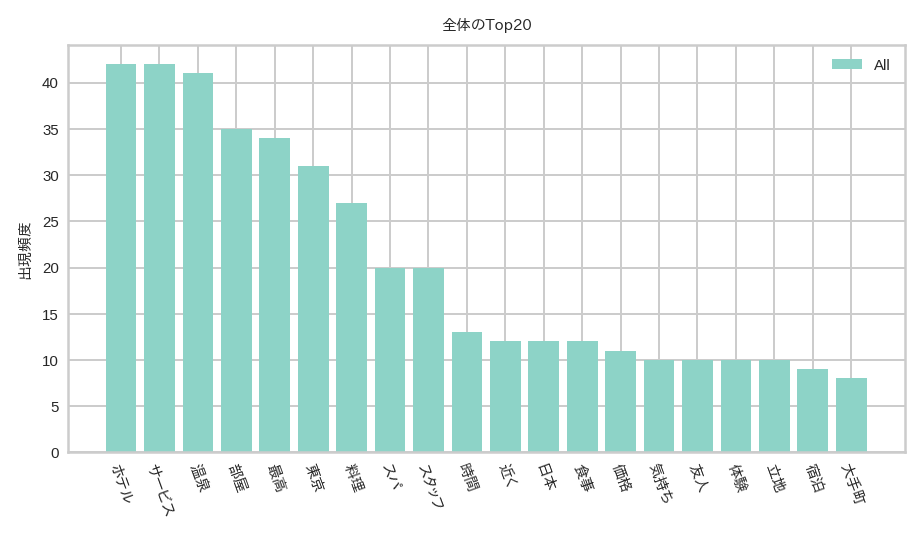

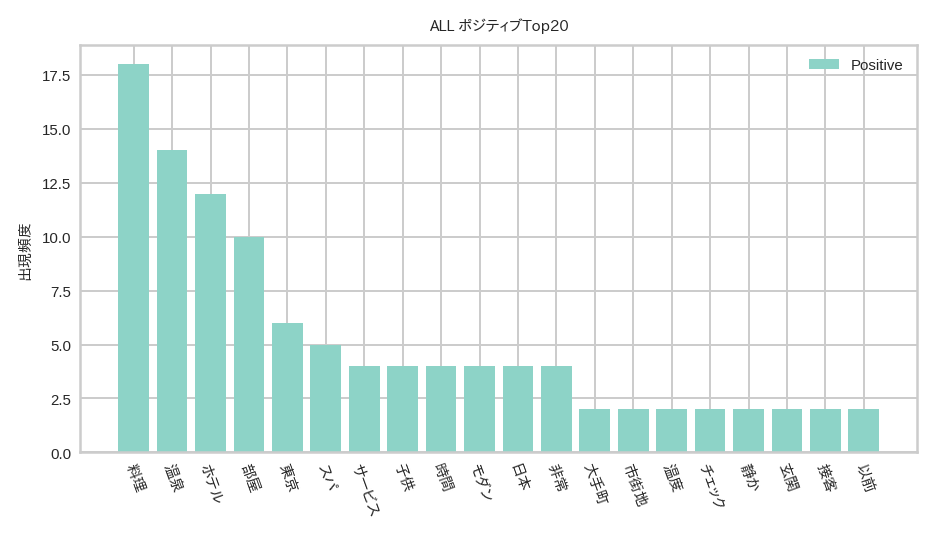

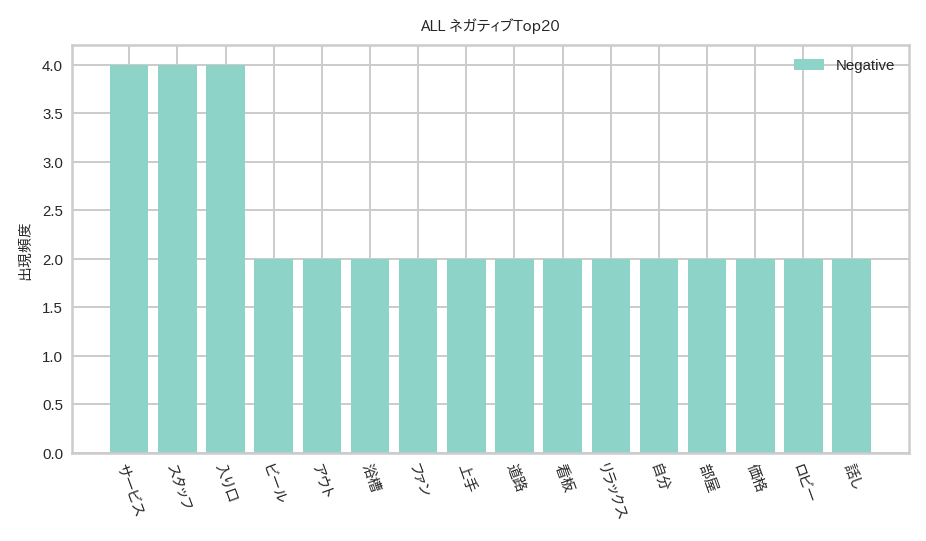

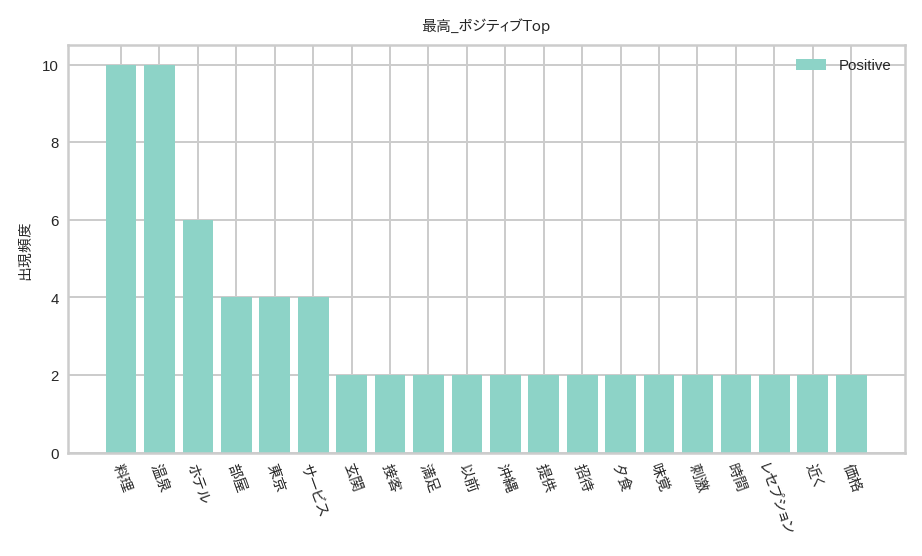

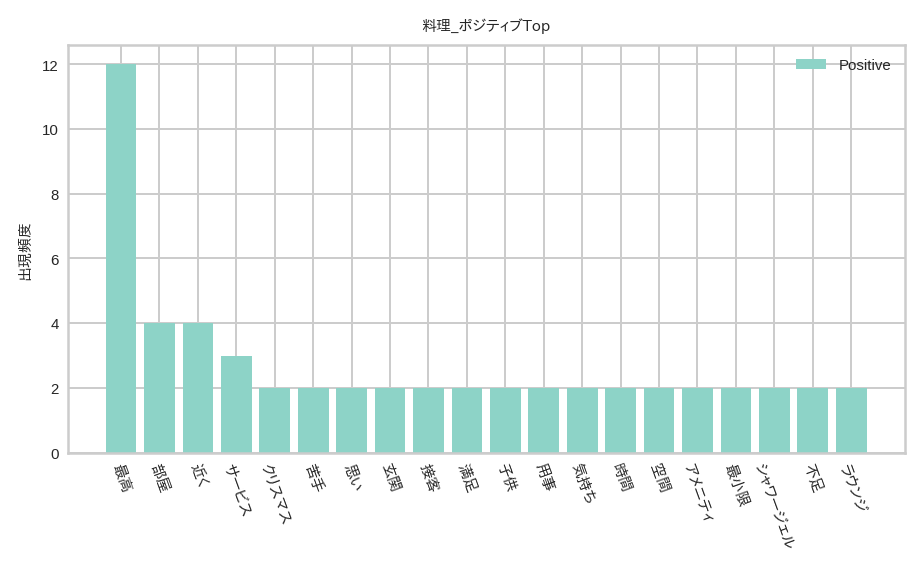

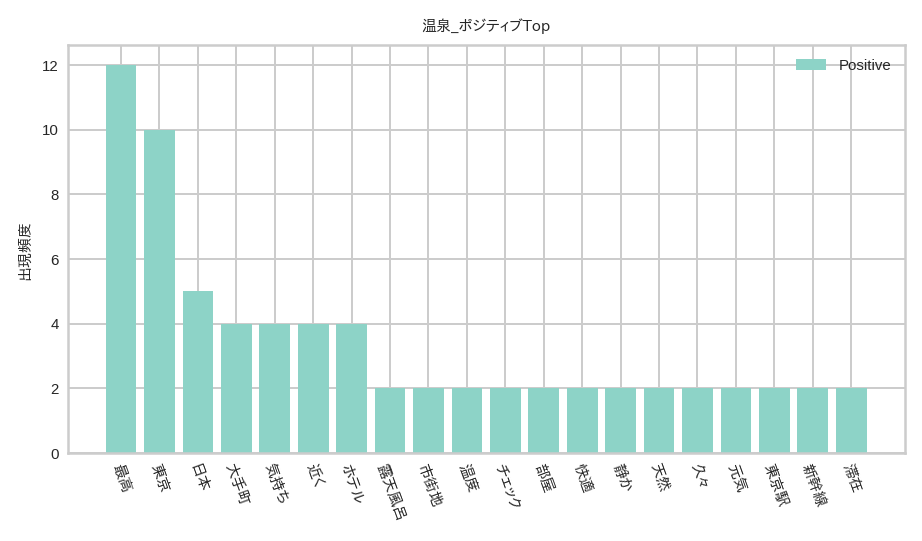

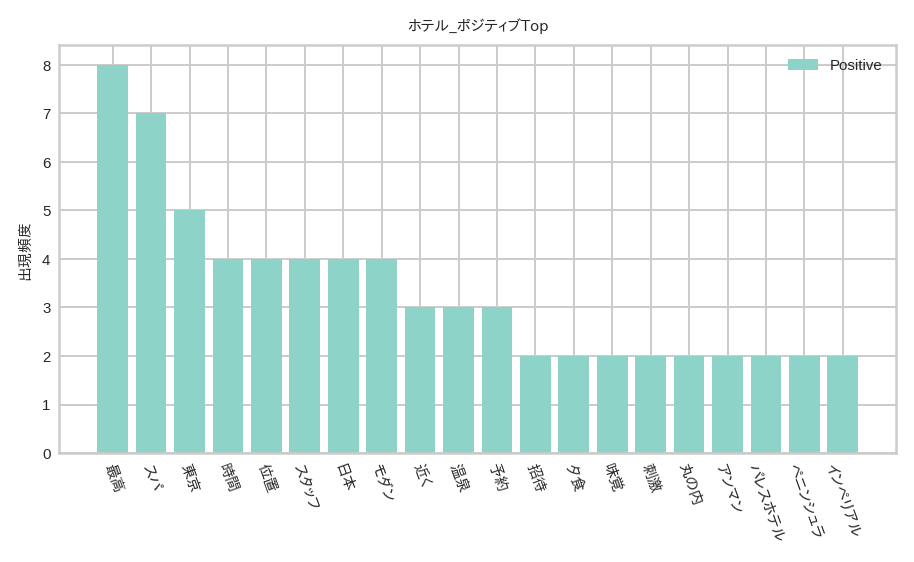

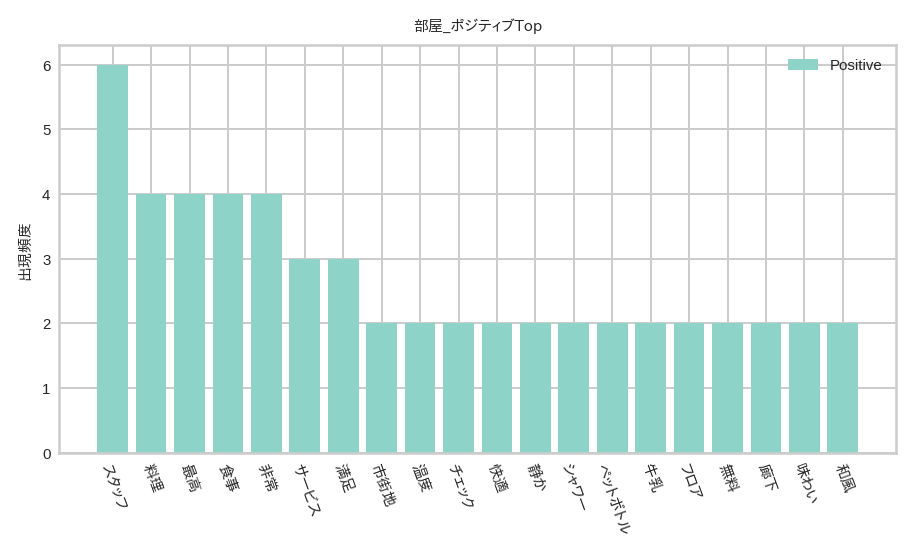

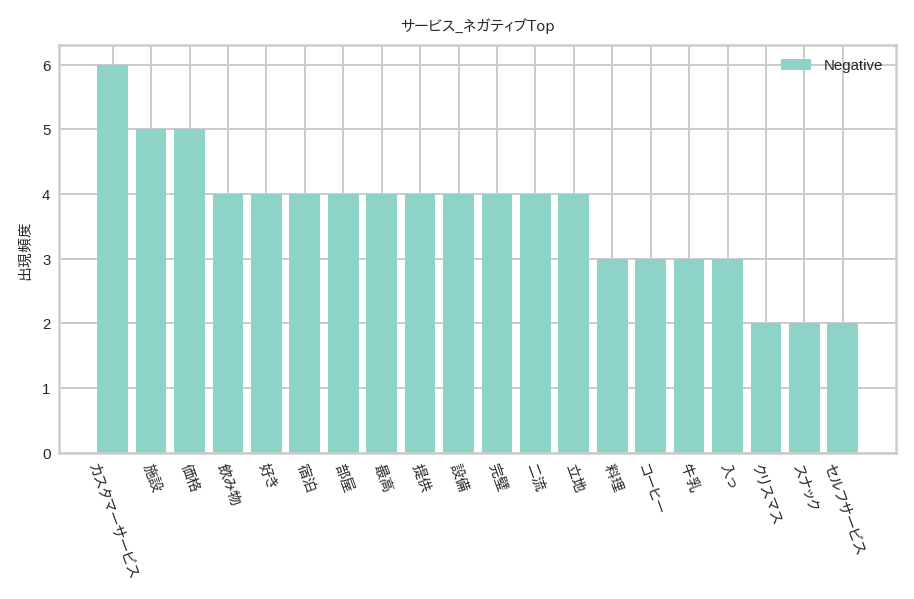

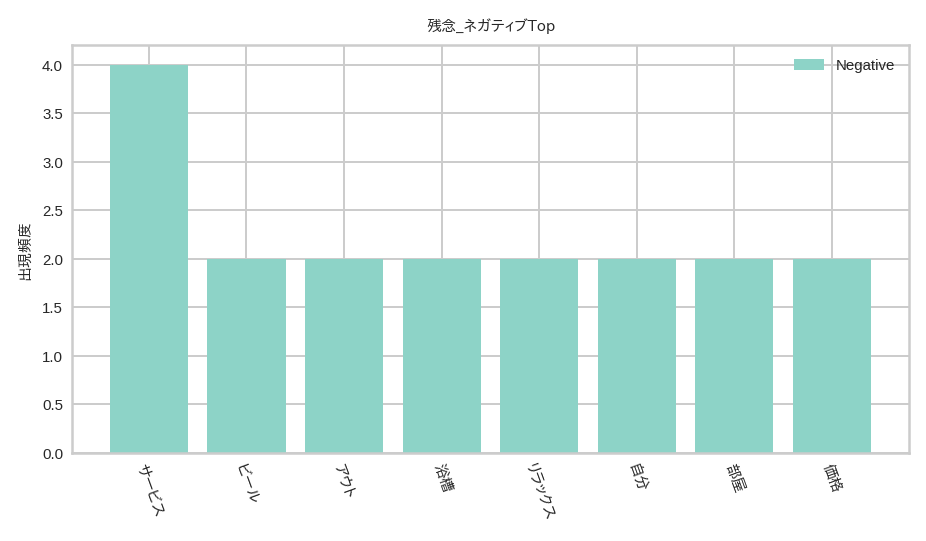

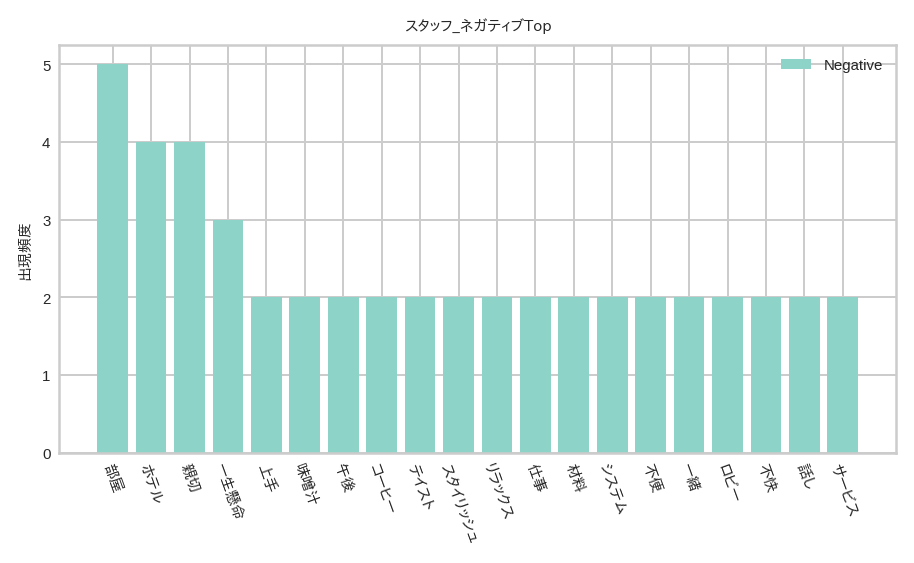

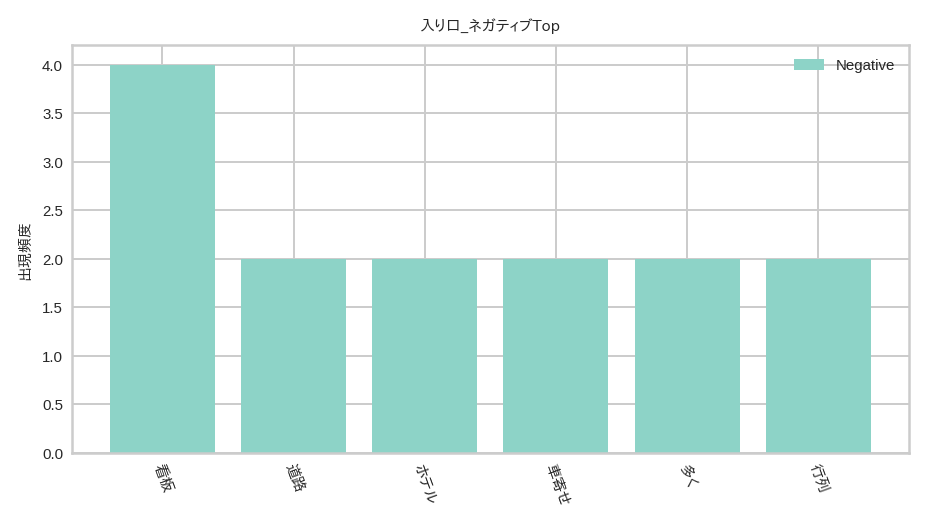

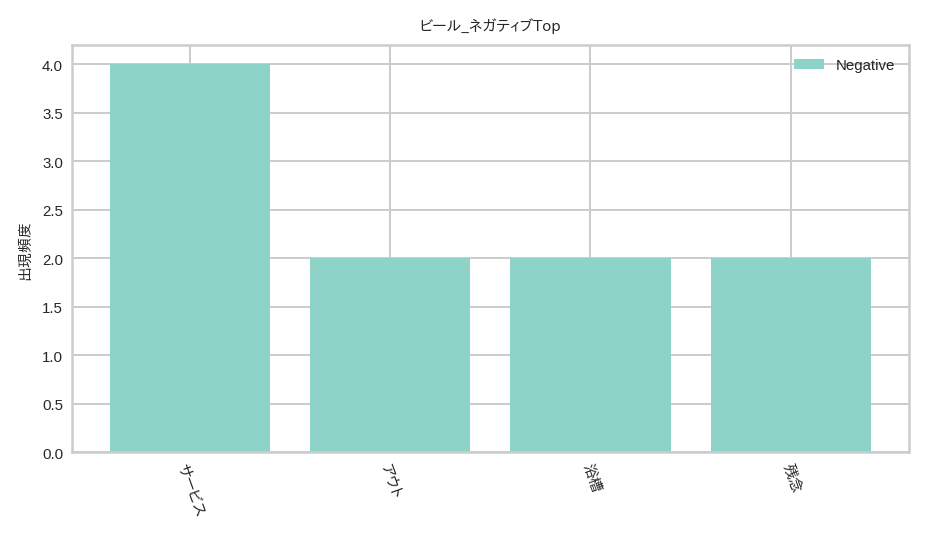

In [ ]:
#出力　グラフ
def fn_plot_word(data_tupAry, topN_num , dataName_str, title_str, saveFileName_str="WordCount.png" ):
  resultTopNKeywords_ary=  [_tup[0] for _tup in data_tupAry[0:topN_num]]
  resultTopNCount_ary =  [_tup[1] for _tup in data_tupAry[0:topN_num]]
  resultTopNCount_map = {dataName_str : resultTopNCount_ary } 
  plot_word_dist(resultTopNKeywords_ary , resultTopNCount_map,title_str, saveFileName_str=saveFileName_str )

def fn_eraseWordCountMapData_tupAry(data_tupAry, eraseKey_ary):
  _result_ary = []
  for data_tup in data_tupAry:
    if not data_tup[0] in eraseKey_ary:
      _result_ary.append(data_tup)
  return _result_ary 

#出力 --テキスト--
def fn_makeText_df(textDataFrame_df, text_tupAry):
  columns_ary = ["Keyword","Text"]
  _df = pd.DataFrame()
  for result_tup in text_tupAry:
    _text_df = fn_getTextIncludeWords_df(textDataFrame_df,[result_tup[0]])
    _text_str = re.sub(" ","",_text_df[0].to_string(index=False) )
    for _tx_str in _text_str.split("\n"):
      _data_map = {"Keyword":result_tup[0], "Text":_tx_str}
      _df = _df.append(_data_map ,  ignore_index=True)
  return _df

#--ALL--
fn_plot_word(resultAll_tupAry, 20 , "All", "全体のTop20", saveFileName_str="WordCount_all.png" )
resultAllTopN_df = fn_makeText_df(textDataFrame_df, resultAll_tupAry)
resultAllTopN_df.to_csv("textData_All.csv")

#--ポジティブ--
resultPositive_tupAry = fn_eraseWordCountMapData_tupAry(resultPositive_tupAry,positveWords_strAry)
fn_plot_word(resultPositive_tupAry, 20 , "Positive", "ALL ポジティブTop20", saveFileName_str="WordCount_positive.png" )
resultPositive_df = fn_makeText_df(textDataFrame_df, resultPositive_tupAry)
resultPositive_df.to_csv(f"textData_positive.csv")

#--ネガティブ--
resultNegative_tupAry = fn_eraseWordCountMapData_tupAry(resultNegative_tupAry, negativeWords_strAry)
fn_plot_word(resultNegative_tupAry, 20 , "Negative", "ALL ネガティブTop20", saveFileName_str="WordCount_negative.png" )
resultNegative_df = fn_makeText_df(textDataFrame_df, resultPositive_tupAry)
resultNegative_df.to_csv(f"textData_negative.csv")

#--ポジティブ共起--
for _ky,_positiveCooccurrenceWords_ary in  positiveCooccurrenceWords_map.items():
  resultPositiveCo_tupAry = fn_eraseWordCountMapData_tupAry(_positiveCooccurrenceWords_ary,[_ky])
  _size_num = 20 if len(resultPositiveCo_tupAry) > 20 else   len(resultPositiveCo_tupAry)
  fn_plot_word(resultPositiveCo_tupAry, _size_num  , "Positive", f"{_ky}_ポジティブTop", saveFileName_str=f"WordCount_positive_{_ky}.png" )
  resultPositiveCo_df = fn_makeText_df(textDataFrame_df, resultPositive_tupAry)
  resultPositiveCo_df.to_csv(f"textData_positiveCo.csv")

#--ネガティブ共起--
for _ky,_negativeCooccurrenceWords_ary in  negativeCooccurrenceWords_map.items():
  resultNegativeCo_tupAry = fn_eraseWordCountMapData_tupAry(_negativeCooccurrenceWords_ary,[_ky])
  _size_num = 20 if len(resultNegativeCo_tupAry ) > 20 else   len(resultNegativeCo_tupAry)
  fn_plot_word(resultNegativeCo_tupAry, 20 , "Negative", f"{_ky}_ネガティブTop",saveFileName_str= f"WordCount_negative_{_ky}.png" )
  resultNegativeCo_df = fn_makeText_df(textDataFrame_df, resultPositive_tupAry)
  resultNegativeCo_df.to_csv(f"textData_NegativeCo.csv")




